# Dataset paper pinn

In [8]:
# Download the dataset
!wget https://raw.githubusercontent.com/maziarraissi/PINNs/master/main/Data/cylinder_nektar_wake.mat -O ../data/cylinder/cylinder_nektar_wake.mat


--2025-09-11 15:40:01--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/main/Data/cylinder_nektar_wake.mat
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.110.133]:443... 

conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 24081984 (23M) [application/octet-stream]
Guardando como: ‘../data/cylinder/cylinder_nektar_wake.mat’

../data/cylinder/cy 100%[===================>]  22,97M  3,96MB/s    en 8,1s    

2025-09-11 15:40:10 (2,85 MB/s) - ‘../data/cylinder/cylinder_nektar_wake.mat’ guardado [24081984/24081984]



In [5]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt


data = loadmat("../data/cylinder/cylinder_nektar_wake.mat")

In [ ]:
data.keys(), data["X_star"].shape, data['p_star'].shape

(dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star']),
 (5000, 2),
 (5000, 200))

In [6]:
np.unique(data["X_star"][:, 1]).shape

(50,)

(200, 50, 100)


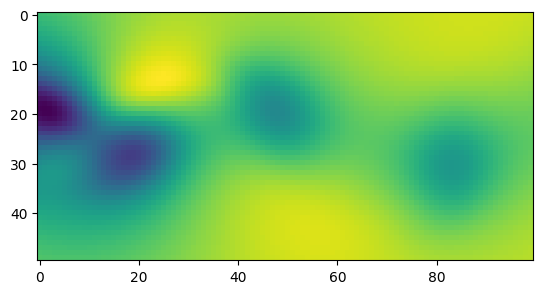

In [7]:
presiones = data['p_star'].reshape(50, 100, -1).transpose(2, 0, 1)
print(presiones.shape)
plt.imshow(presiones[0])
# plt.imshow(data['p_star'][:, 0].reshape(50, 100))

(64, 128)


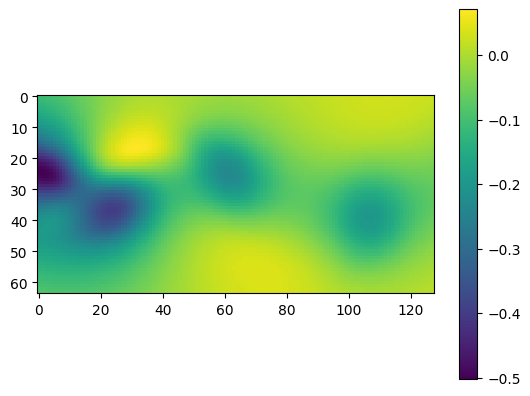

In [8]:
import numpy as np
from scipy.ndimage import zoom


# Calculate zoom factors
zoom_factors = (64/50, 128/100)  # (1.28, 1.28)

# Upsample using bilinear interpolation
upsampled = zoom(presiones[0], zoom_factors, order=1)
print(upsampled.shape)  # Should be (64, 128)
im = plt.imshow(upsampled)
plt.colorbar(im)

In [9]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
im = ax.imshow(presiones[0], animated=True)
plt.colorbar(im)

def update(frame):
    im.set_array(presiones[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=presiones.shape[0], blit=True)
ani.save("presiones.gif", writer="pillow", fps=5)
plt.close(fig)

# Nvidia cylinder dataset

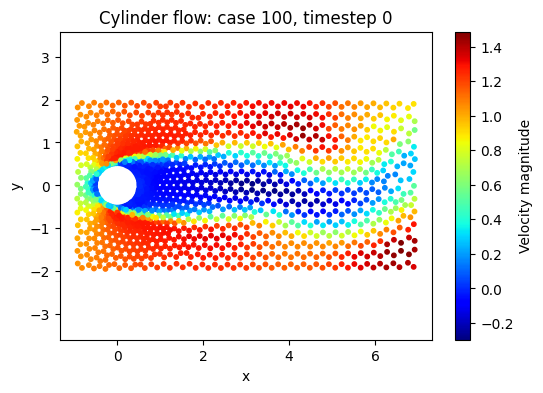

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = np.load("dataset/rawData.npy", allow_pickle=True)#.item()

x = data['x']         # shape (time, case, nodes, vars)
coords = np.loadtxt("dataset/meshPosition_all.txt")  # shape (nodes, 2), columns [x,y]

# Choose one case and one time step
t_idx = 0       # first timestep
case_idx = 100    # first simulation
snapshot = x[t_idx, case_idx]  # shape (nodes, 3)

u = snapshot[:,0]   # x-velocity
v = snapshot[:,1]   # y-velocity
p = snapshot[:,2]   # pressure

# Plot velocity magnitude
vel_mag = np.sqrt(u**2 + v**2)

plt.figure(figsize=(6,4))
sc = plt.scatter(coords[:,0], coords[:,1], c=u, cmap="jet", s=10)
plt.colorbar(sc, label="Velocity magnitude")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Cylinder flow: case {}, timestep {}".format(case_idx, t_idx))
plt.axis("equal")
plt.show()


In [ ]:
import numpy as np
arr = np.load("dataset/rawData.npy", allow_pickle=True)

In [3]:
arr.keys(), arr["x"].shape

(dict_keys(['x', 'edge_attr', 'edge_index', 'mass', 'para']),
 (101, 401, 1699, 3))

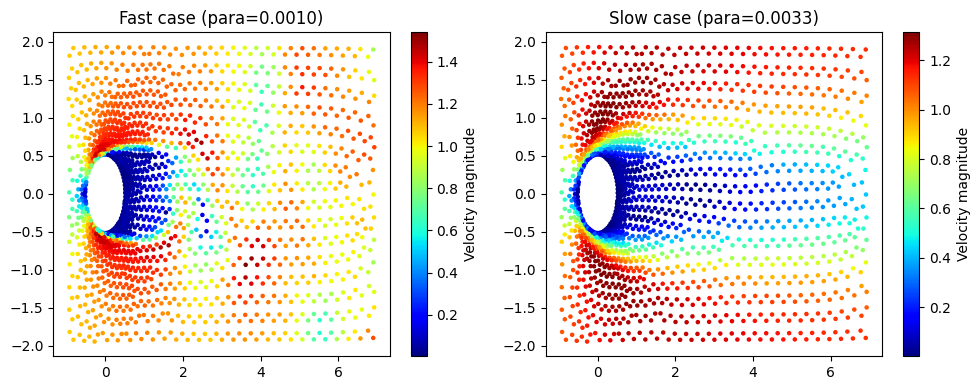

In [18]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("dataset/rawData.npy", allow_pickle=True)#.item()
coords = np.loadtxt("dataset/meshPosition_all.txt")
x = data['x']
para = data['para']

# Pick two cases: smallest vs largest parameter
case_fast = np.argmin(para)
case_slow = np.argmax(para)

# Take final timestep snapshot
t_idx = -1
snap_fast = x[t_idx, case_fast]
snap_slow = x[t_idx, case_slow]

u_fast, v_fast = snap_fast[:,0], snap_fast[:,1]
u_slow, v_slow = snap_slow[:,0], snap_slow[:,1]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(coords[:,0], coords[:,1], c=np.sqrt(u_fast**2+v_fast**2), s=5, cmap="jet")
plt.colorbar(label="Velocity magnitude")
plt.title(f"Fast case (para={para[case_fast]:.4f})")

plt.subplot(1,2,2)
plt.scatter(coords[:,0], coords[:,1], c=np.sqrt(u_slow**2+v_slow**2), s=5, cmap="jet")
plt.colorbar(label="Velocity magnitude")
plt.title(f"Slow case (para={para[case_slow]:.4f})")

plt.tight_layout()
plt.show()


# CFDBench dataset

In [ ]:
from huggingface_hub import snapshot_download

# Download the whole CFDBench repo
dataset_path = snapshot_download(repo_id="chen-yingfa/CFDBench", repo_type="dataset", local_dir="../data/datasetCFDBench")

print("Dataset downloaded to:", dataset_path)


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/807 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

bc.zip:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

cavity.zip:   0%|          | 0.00/786M [00:00<?, ?B/s]

tube.zip:   0%|          | 0.00/213M [00:00<?, ?B/s]

geo.zip:   0%|          | 0.00/2.41G [00:00<?, ?B/s]

dam.zip:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

prop.zip:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

Dataset downloaded to: /home/d.ramos/pyLowOrder/datasetCFDBench


In [6]:
import numpy as np
import zipfile

# pick a case index
case_idx = "0000"

# open geo (geometry)
with zipfile.ZipFile("datasetCFDBench/cylinder/geo.zip") as z:
    # unzip the file
    z.extractall("datasetCFDBench/cylinder/geo")

# open bc (boundary conditions)
with zipfile.ZipFile("datasetCFDBench/cylinder/bc.zip") as z:
    z.extractall("datasetCFDBench/cylinder/bc")


# open prop (properties)
with zipfile.ZipFile("datasetCFDBench/cylinder/prop.zip") as z:
    z.extractall("datasetCFDBench/cylinder/prop")



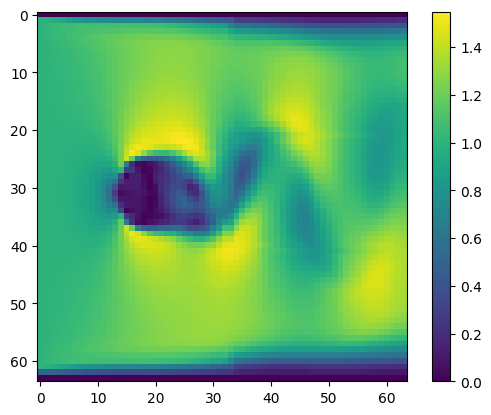

In [5]:
import numpy as np
import matplotlib.pyplot as plt

caso_ejemplo = "datasetCFDBench/cylinder/prop/case0060/u.npy"
u_ejemplo = np.load(caso_ejemplo)
im = plt.imshow(u_ejemplo[-1])
plt.colorbar(im)

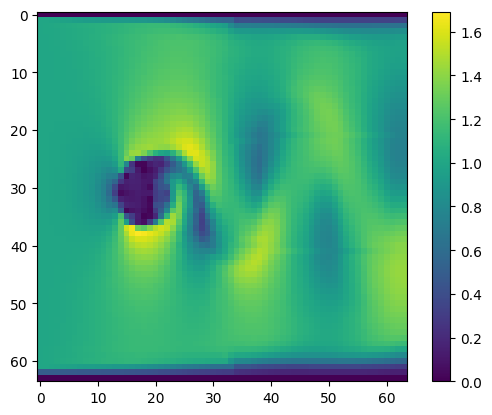

In [11]:
caso_ejemplo = "datasetCFDBench/cylinder/prop/case0070/u.npy"
u_ejemplo = np.load(caso_ejemplo)
im = plt.imshow(u_ejemplo[-1])
plt.colorbar(im)

In [14]:
import pandas as pd
from pathlib import Path

prop_dir = "datasetCFDBench/cylinder/prop/"

In [30]:
df = None
for file in Path(prop_dir).glob("case*/case.json"):
    if df is None:
        print("Reading first file:", file)
        df = pd.read_json(file, typ='series').to_frame().T
        continue
    json_data = pd.read_json(file, typ='series').to_frame().T
    df = pd.concat([df, json_data], ignore_index=True)


Reading first file: datasetCFDBench/cylinder/prop/case0050/case.json


In [31]:
df

,vel_in,density,viscosity,radius,x_min,x_max,y_min,y_max
0,1.0,1.0,0.0010,0.01,-0.06,0.16,-0.06,0.06
1,1.0,2.0,0.0010,0.01,-0.06,0.16,-0.06,0.06
2,1.0,3.0,0.0010,0.01,-0.06,0.16,-0.06,0.06
3,1.0,4.0,0.0010,0.01,-0.06,0.16,-0.06,0.06
4,1.0,5.0,0.0010,0.01,-0.06,0.16,-0.06,0.06
...,...,...,...,...,...,...,...,...
111,1.0,6.0,0.0005,0.01,-0.06,0.16,-0.06,0.06
112,1.0,7.0,0.0005,0.01,-0.06,0.16,-0.06,0.06
113,1.0,8.0,0.0005,0.01,-0.06,0.16,-0.06,0.06
114,1.0,9.0,0.0005,0.01,-0.06,0.16,-0.06,0.06


In [34]:
df["density"].value_counts(), df["viscosity"].value_counts(), df["x_max"].value_counts()

(density
 1.0      4
 2.0      4
 3.0      4
 4.0      4
 5.0      4
 10.0     4
 6.0      3
 7.0      3
 8.0      3
 9.0      3
 50.0     3
 30.0     3
 40.0     3
 20.0     3
 11.0     2
 12.0     2
 13.0     2
 14.0     2
 15.0     2
 19.0     2
 18.0     2
 17.0     2
 16.0     2
 60.0     2
 70.0     2
 80.0     2
 90.0     2
 100.0    2
 0.7      2
 0.8      2
 0.5      2
 0.2      2
 0.3      2
 0.4      2
 0.9      2
 0.6      2
 0.1      2
 120.0    1
 110.0    1
 140.0    1
 150.0    1
 160.0    1
 130.0    1
 250.0    1
 240.0    1
 230.0    1
 220.0    1
 210.0    1
 200.0    1
 190.0    1
 180.0    1
 170.0    1
 400.0    1
 500.0    1
 300.0    1
 1.5      1
 2.5      1
 3.5      1
 4.5      1
 Name: count, dtype: int64,
 viscosity
 0.0050    28
 0.0100    28
 0.0010    23
 0.0005    19
 0.0001    18
 Name: count, dtype: int64,
 x_max
 0.16    116
 Name: count, dtype: int64)

# Dataset Laplace

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "../data/laplace"

In [4]:
simulations = np.load(f"{data_dir}/laplace_dataset_solutions.npy")  # shape (num_simulations, height, width)
parameters = np.load(f"{data_dir}/laplace_dataset_parameters.npy")  # shape (num_simulations, 2)

In [5]:
# normalize the simulations to [0, 1]
sim_min = simulations.min(axis=(1,2), keepdims=True)
sim_max = simulations.max(axis=(1,2), keepdims=True)
simulations_norm = (simulations - sim_min) / (sim_max - sim_min)


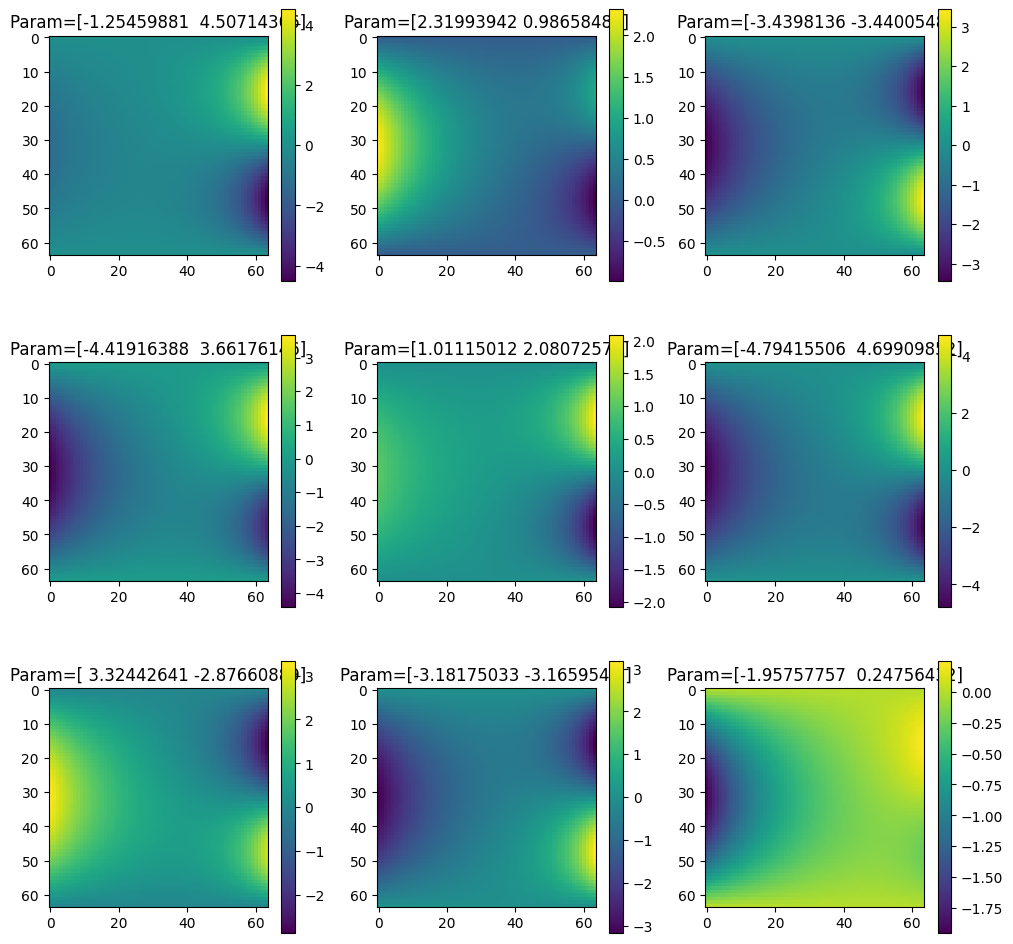

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(simulations[i])#, vmin=np.min(simulations), vmax=np.max(simulations))#, cmap="jet")
    ax.set_title(f"Param={parameters[i]}")
    plt.colorbar(im, ax=ax)



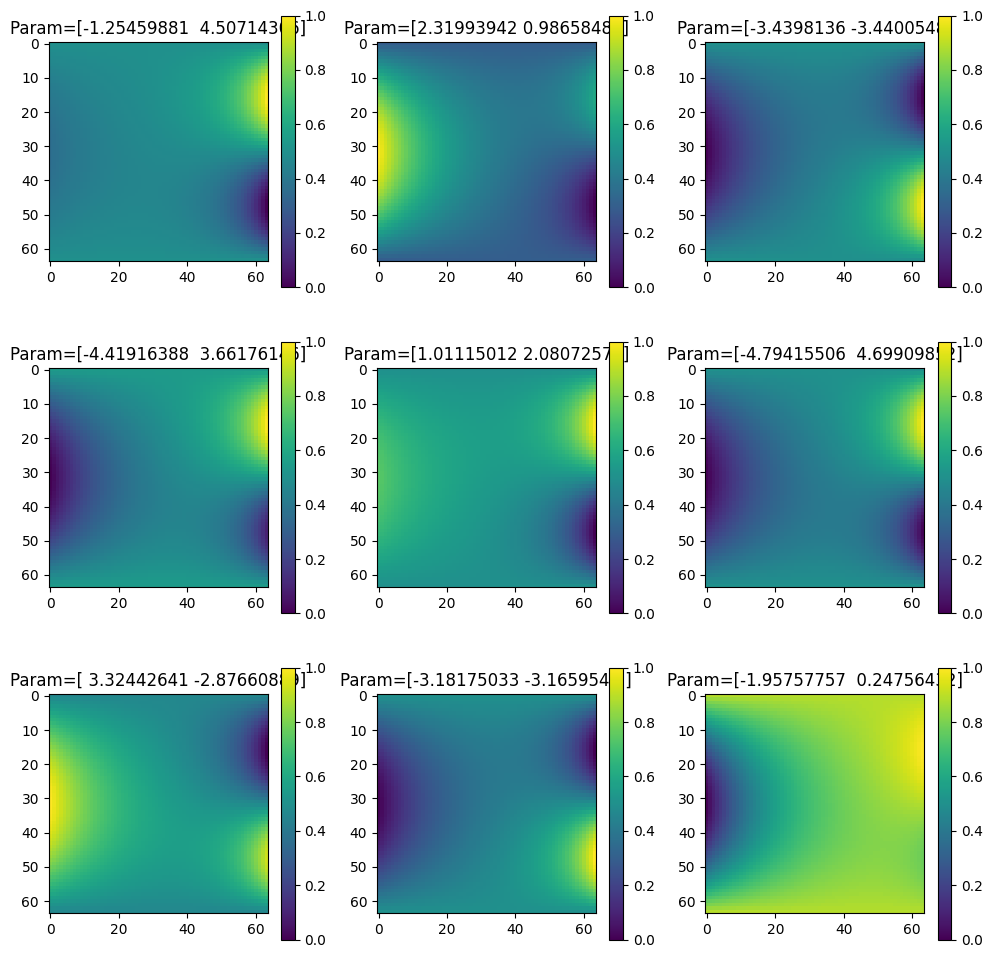

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(simulations_norm[i])
    ax.set_title(f"Param={parameters[i]}")
    plt.colorbar(im, ax=ax)

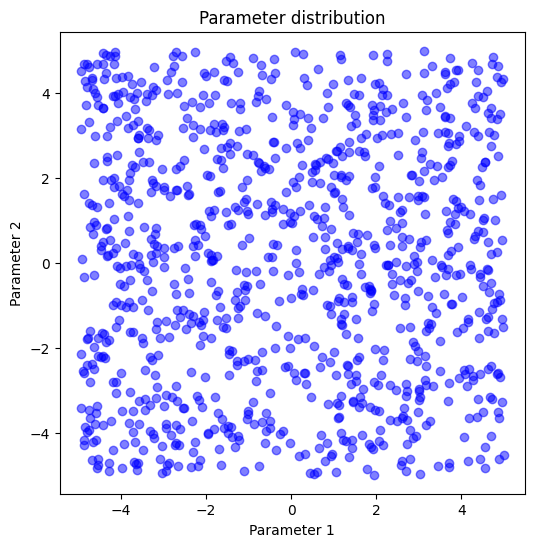

In [8]:
# scatter plot of parameters

plt.figure(figsize=(6,6))
plt.scatter(parameters[:,0], parameters[:,1], c='blue', alpha=0.5)
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Parameter distribution")
plt.axis("equal")
plt.show()

In [8]:
from generate_laplace_data import LaplaceDatasetGenerator
import matplotlib.pyplot as plt


In [9]:
generator = LaplaceDatasetGenerator(nx=64, ny=64, Lx=1.0, Ly=1.0)

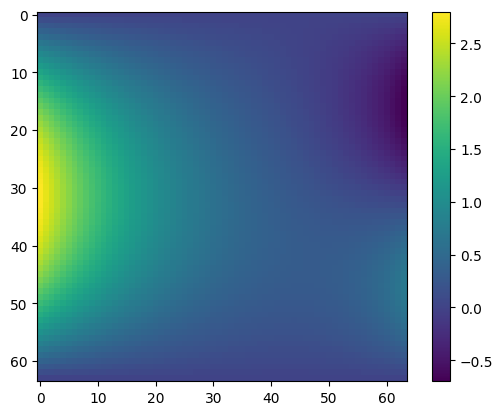

In [15]:
initial_alpha1, initial_alpha2 = 0.78, 0.43
min_alpha, max_alpha = -5, 5
scaled_alpha1 = initial_alpha1 * (max_alpha - min_alpha) + min_alpha
scaled_alpha2 = initial_alpha2 * (max_alpha - min_alpha) + min_alpha
solution, parameters = generator.solve_laplace(scaled_alpha1, scaled_alpha2)

def normalize_to_0_1(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

plt.imshow(solution)
plt.colorbar()

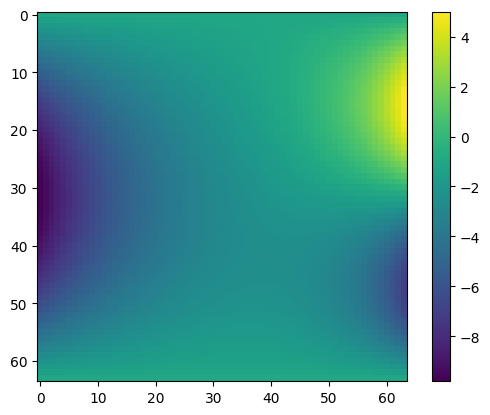

In [6]:
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

norm = normalize_to_neg_one_to_one(solution)
sol = unnormalize_to_zero_to_one(norm)
plt.imshow(norm)
plt.colorbar()

# Dataset DLR

In [1]:
from netCDF4 import Dataset
import os
import numpy as np

In [2]:
fname = "../data/dlr_airfoils/test/Snap_Case0060_M0.63047_AoA1.64198"
nc_fid = Dataset(fname, 'r')
x = nc_fid.variables["x"][: 597]
z = nc_fid.variables["z"][: 597]
cp = nc_fid.variables["cp"][: 597]
mach = nc_fid.Mach
alpha = nc_fid.Alpha    

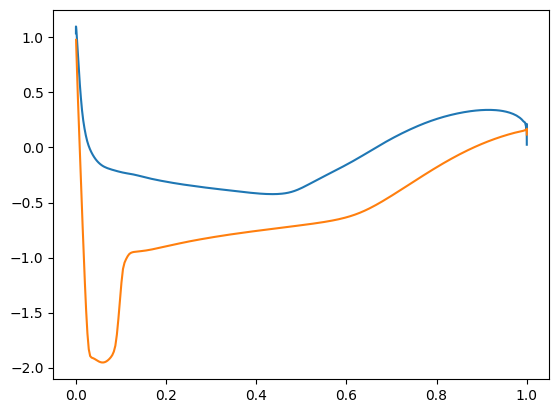

In [3]:
import matplotlib.pyplot as plt

plt.plot(x[:597//2], cp[:597//2])#, marker='.')
plt.plot(x[597//2:], cp[597//2:])#, marker='.', c='green')

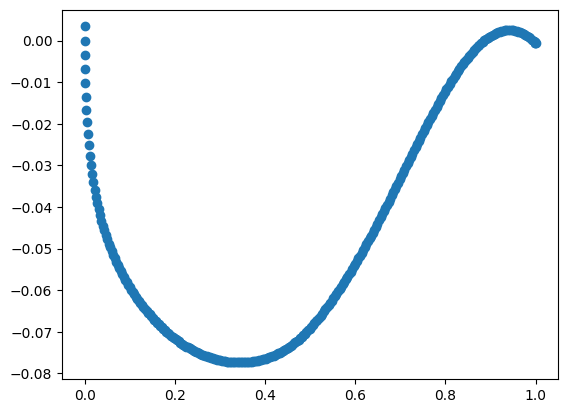

In [4]:
plt.scatter(x[:597//2], z[:597//2])
# plt.scatter(x[597//2:], z[597//2:])
# plt.scatter(x[298], z[298], marker='.')

In [5]:
x[297], z[297], x[298], z[298], x[299], z[299]

(1.0, -0.0005455, 1.0, -0.00036365, 1.0, -0.0001818)

In [6]:
x[:597//2].shape, x[597//2:].shape

((298,), (299,))

shape a tener en el dataset:  
(N_airfoils, 2, Num_puntos / 2)  
2 --> parte de arriba y parte de abajo  
Para la longitud de secuencia hay que tener en cuanta que el numero de puntos es impar, asi que hay que hacer algo ahi.

In [7]:
training_files = os.listdir("../data/dlr_airfoils/train/") 
training_files = list(map(lambda x: "../data/dlr_airfoils/train/" + x, training_files))
val_files = os.listdir("../data/dlr_airfoils/val/") 
val_files = list(map(lambda x: "../data/dlr_airfoils/val/" + x, val_files))
test_files = os.listdir("../data/dlr_airfoils/val")
test_files = list(map(lambda x: "../data/dlr_airfoils/val/" + x, test_files))
training_files = training_files + val_files

In [8]:
def generate_arrays(files: list):
    airfoils, conditions = [], []
    for file_name in files:
        nc_fid = Dataset(file_name, 'r')
        cp = nc_fid.variables["cp"][: 597]
        mach = nc_fid.Mach
        alpha = nc_fid.Alpha
        cp_lower = cp[:298]
        cp_upper = cp[299:]
        conditions.append([mach, alpha])
        airfoils.append(np.vstack((cp_lower, cp_upper)))
        # print(np.vstack((cp_lower, cp_upper)).shape)
    
    airfoils = np.stack(airfoils, axis=0)
    conditions = np.array(conditions)

    return airfoils, conditions

In [9]:
airfoils_train, conditions_train = generate_arrays(training_files)
airfoils_train.shape, conditions_train.shape

((59, 2, 298), (59, 2))

In [14]:
np.save("../data/dlr_airfoils/cp_train.npz", np.array(airfoils_train))
np.save("../data/dlr_airfoils/conditions_train.npz", conditions_train)

In [15]:
airfoils_test, conditions_test = generate_arrays(test_files)
np.save("../data/dlr_airfoils/cp_test.npz", np.array(airfoils_test))
np.save("../data/dlr_airfoils/conditions_test.npz", conditions_test)

# Non-linear equation dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class AnalyticalFunctionDataset:
    def __init__(self, nx=64, ny=64, x_range=(0, 2*np.pi), y_range=(0, 2*np.pi)):
        """
        Initialize the analytical function dataset generator.
        
        Parameters:
        - nx, ny: Number of grid points in x and y directions
        - x_range, y_range: Domain ranges for x and y coordinates
        """
        self.nx = nx
        self.ny = ny
        self.x_range = x_range
        self.y_range = y_range
        
        # Create coordinate grids
        x = np.linspace(x_range[0], x_range[1], nx)
        y = np.linspace(y_range[0], y_range[1], ny)
        self.X, self.Y = np.meshgrid(x, y)
        
        print(f"Grid initialized: {nx}x{ny}")
        print(f"X domain: [{x_range[0]:.2f}, {x_range[1]:.2f}]")
        print(f"Y domain: [{y_range[0]:.2f}, {y_range[1]:.2f}]")
    
    def evaluate_function(self, alpha1, alpha2):
        """
        Evaluate a complex nonlinear function with chaotic behavior:
        f(x,y) = α₁*sin(α₂*x + y)*cos(x*y/α₁) + α₂*exp(-((x-π)² + (y-π)²)/(2*α₁²))*sin(α₁*x*y)
        
        Parameters:
        - alpha1, alpha2: Function parameters
        
        Returns:
        - result: 2D array with function values
        - parameters: dict with parameter values
        """
        # Avoid division by zero
        alpha1_safe = alpha1 if abs(alpha1) > 0.1 else 0.1 * np.sign(alpha1) if alpha1 != 0 else 0.1
        
        # Term 1: Coupled oscillations with frequency modulation
        term1 = alpha1 * np.sin(alpha2 * self.X + self.Y) * np.cos(self.X * self.Y / alpha1_safe)
        
        # Term 2: Gaussian-modulated nonlinear interaction
        gaussian = np.exp(-((self.X - np.pi)**2 + (self.Y - np.pi)**2) / (2 * alpha1_safe**2))
        term2 = alpha2 * gaussian * np.sin(alpha1 * self.X * self.Y / 5.0)  # Scale down the product to avoid extreme oscillations
        
        # Term 3: Add some chaos with a nonlinear combination
        term3 = 0.3 * np.tanh(alpha1 * np.sin(2*self.X) + alpha2 * np.cos(3*self.Y))
        
        # Term 4: Interference patterns
        term4 = 0.2 * alpha1 * alpha2 * np.sin(self.X + alpha2) * np.sin(self.Y + alpha1) / (1 + 0.1 * (self.X**2 + self.Y**2))
        
        result = term1 + term2 + term3 + term4
        
        parameters = {'alpha1': alpha1, 'alpha2': alpha2}
        
        return result, parameters
    
    def generate_dataset(self, n_samples, alpha1_range=(-2.0, 2.0), alpha2_range=(-2.0, 2.0), 
                        random_seed=42):
        """
        Generate a dataset of function evaluations.
        
        Parameters:
        - n_samples: Number of samples to generate
        - alpha1_range, alpha2_range: Ranges for parameter sampling
        - random_seed: Random seed for reproducibility
        
        Returns:
        - solutions: Array of shape (n_samples, ny, nx)
        - parameters: Array of shape (n_samples, 2) with [alpha1, alpha2]
        """
        np.random.seed(random_seed)
        
        solutions = []
        parameters = []
        
        print(f"Generating {n_samples} samples...")
        
        for i in range(n_samples):
            # Sample parameters uniformly
            alpha1 = np.random.uniform(*alpha1_range)
            alpha2 = np.random.uniform(*alpha2_range)
            
            # Evaluate function
            solution, params = self.evaluate_function(alpha1, alpha2)
            
            solutions.append(solution)
            parameters.append([alpha1, alpha2])
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{n_samples} samples")
        
        solutions = np.array(solutions)
        parameters = np.array(parameters)
        
        print(f"Dataset generation complete!")
        
        return solutions, parameters
    
    def generate_grid_dataset(self, alpha1_values, alpha2_values):
        """
        Generate a dataset on a regular grid of parameter values.
        
        Parameters:
        - alpha1_values: Array of alpha1 values
        - alpha2_values: Array of alpha2 values
        
        Returns:
        - solutions: Array of shape (n_alpha1 * n_alpha2, ny, nx)
        - parameters: Array of shape (n_alpha1 * n_alpha2, 2)
        """
        solutions = []
        parameters = []
        
        total_samples = len(alpha1_values) * len(alpha2_values)
        print(f"Generating {total_samples} samples on regular grid...")
        
        count = 0
        for alpha1 in alpha1_values:
            for alpha2 in alpha2_values:
                solution, params = self.evaluate_function(alpha1, alpha2)
                solutions.append(solution)
                parameters.append([alpha1, alpha2])
                
                count += 1
                if count % 100 == 0:
                    print(f"Generated {count}/{total_samples} samples")
        
        solutions = np.array(solutions)
        parameters = np.array(parameters)
        
        return solutions, parameters
    
    def save_dataset(self, solutions, parameters, filename_prefix="analytical_dataset"):
        """Save the dataset to numpy files."""
        np.save(f"{filename_prefix}_solutions.npy", solutions)
        np.save(f"{filename_prefix}_parameters.npy", parameters)
        
        print(f"\nDataset saved as {filename_prefix}_solutions.npy and {filename_prefix}_parameters.npy")
        print(f"Solutions shape: {solutions.shape}")
        print(f"Parameters shape: {parameters.shape}")
        print(f"Solutions range: [{solutions.min():.4f}, {solutions.max():.4f}]")
    
    def visualize_samples(self, solutions, parameters, n_samples=9, figsize=(12, 10)):
        """Visualize some samples from the dataset."""
        n_samples = min(n_samples, len(solutions))
        indices = np.random.choice(len(solutions), n_samples, replace=False)
        
        rows = int(np.ceil(np.sqrt(n_samples)))
        cols = int(np.ceil(n_samples / rows))
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        if n_samples == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_samples > 1 else axes
        
        for i, idx in enumerate(indices):
            if i >= len(axes):
                break
                
            # im = axes[i].contourf(self.X, self.Y, solutions[idx], levels=50, cmap='RdBu_r')
            im = axes[i].imshow(solutions[idx], cmap='RdBu_r')
            axes[i].set_title(f'α₁={parameters[idx][0]:.2f}, α₂={parameters[idx][1]:.2f}')
            axes[i].set_xlabel('x')
            axes[i].set_ylabel('y')
            axes[i].set_aspect('equal')
            plt.colorbar(im, ax=axes[i])
        
        # Hide empty subplots
        for i in range(len(indices), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_dataset(self, solutions, parameters):
        """Analyze the generated dataset."""
        print("\n" + "="*50)
        print("DATASET ANALYSIS")
        print("="*50)
        
        print(f"Function: Complex nonlinear function with multiple interacting terms")
        print(f"f(x,y) = α₁*sin(α₂*x + y)*cos(x*y/α₁) + α₂*exp(-((x-π)² + (y-π)²)/(2*α₁²))*sin(α₁*x*y/5)")
        print(f"       + 0.3*tanh(α₁*sin(2x) + α₂*cos(3y)) + 0.2*α₁*α₂*sin(x+α₂)*sin(y+α₁)/(1+0.1*(x²+y²))")
        print(f"Number of samples: {len(solutions)}")
        print(f"Grid size: {self.nx} × {self.ny}")
        print(f"Domain: x ∈ [{self.x_range[0]:.2f}, {self.x_range[1]:.2f}], y ∈ [{self.y_range[0]:.2f}, {self.y_range[1]:.2f}]")
        
        print(f"\nParameter Statistics:")
        print(f"α₁: min={parameters[:, 0].min():.3f}, max={parameters[:, 0].max():.3f}, mean={parameters[:, 0].mean():.3f}")
        print(f"α₂: min={parameters[:, 1].min():.3f}, max={parameters[:, 1].max():.3f}, mean={parameters[:, 1].mean():.3f}")
        
        print(f"\nFunction Values:")
        print(f"f(x,y): min={solutions.min():.3f}, max={solutions.max():.3f}, mean={solutions.mean():.3f}")
        print(f"Standard deviation: {solutions.std():.3f}")
        
        # Theoretical maximum (when both sin and cos are at their peaks)
        max_alpha1 = max(abs(parameters[:, 0].min()), abs(parameters[:, 0].max()))
        max_alpha2 = max(abs(parameters[:, 1].min()), abs(parameters[:, 1].max()))
        theoretical_max = max_alpha1 * max_alpha2
        print(f"Theoretical maximum: ±{theoretical_max:.3f}")

Grid initialized: 64x64
X domain: [0.00, 6.28]
Y domain: [0.00, 6.28]

METHOD 1: Random Parameter Sampling
Generating 200 samples...
Generated 100/200 samples
Generated 200/200 samples
Dataset generation complete!

Dataset saved as non_linear_test_solutions.npy and non_linear_test_parameters.npy
Solutions shape: (200, 64, 64)
Parameters shape: (200, 2)
Solutions range: [-3.4209, 3.2323]

DATASET ANALYSIS
Function: Complex nonlinear function with multiple interacting terms
f(x,y) = α₁*sin(α₂*x + y)*cos(x*y/α₁) + α₂*exp(-((x-π)² + (y-π)²)/(2*α₁²))*sin(α₁*x*y/5)
       + 0.3*tanh(α₁*sin(2x) + α₂*cos(3y)) + 0.2*α₁*α₂*sin(x+α₂)*sin(y+α₁)/(1+0.1*(x²+y²))
Number of samples: 200
Grid size: 64 × 64
Domain: x ∈ [0.00, 6.28], y ∈ [0.00, 6.28]

Parameter Statistics:
α₁: min=-1.980, max=1.962, mean=-0.007
α₂: min=-1.963, max=1.960, mean=-0.040

Function Values:
f(x,y): min=-3.421, max=3.232, mean=0.013
Standard deviation: 0.719
Theoretical maximum: ±3.887


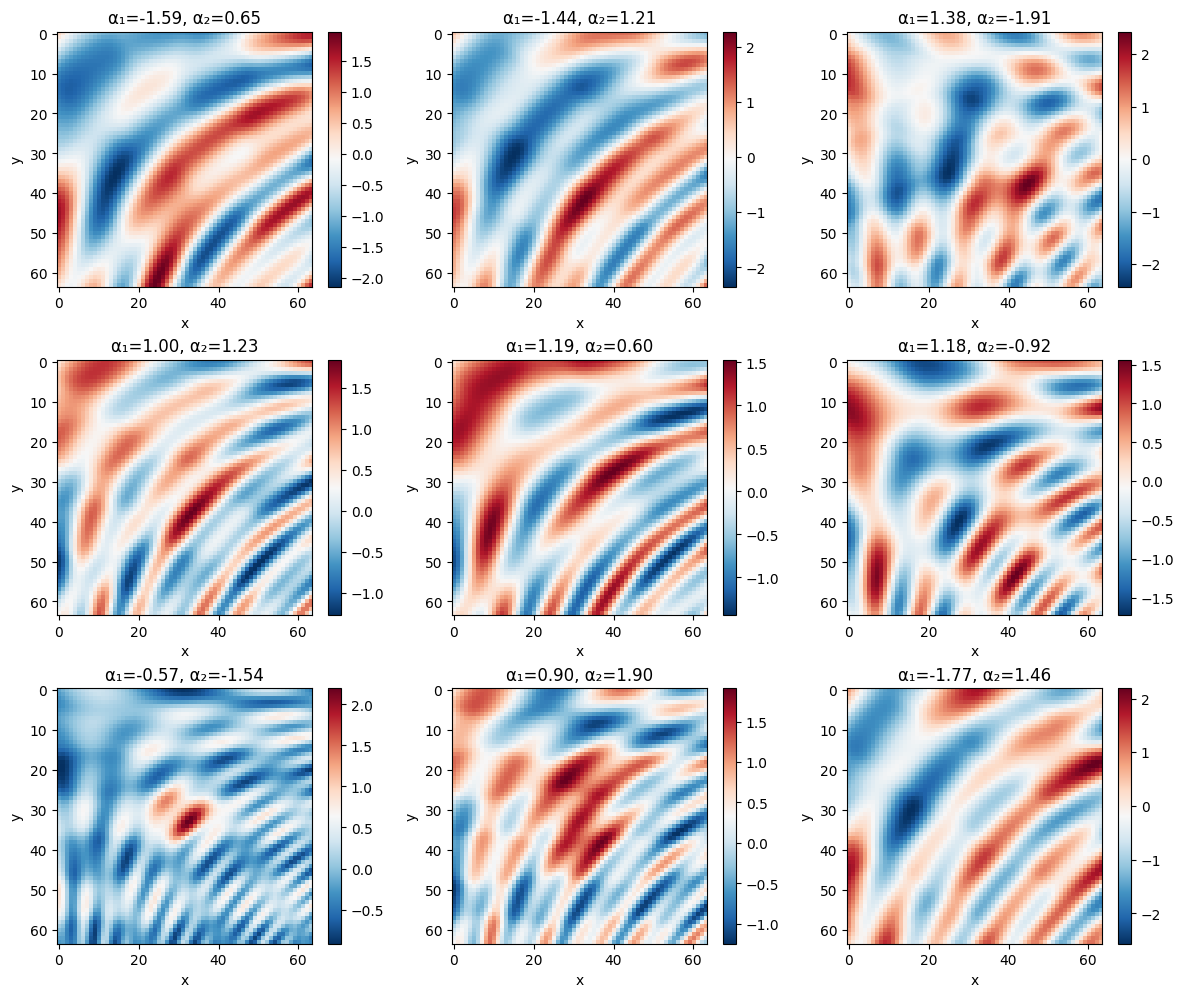

In [4]:
generator = AnalyticalFunctionDataset(nx=64, ny=64, x_range=(0, 2*np.pi), y_range=(0, 2*np.pi))
    
    # Method 1: Random sampling
print("\n" + "="*50)
print("METHOD 1: Random Parameter Sampling")
print("="*50)

solutions_random, parameters_random = generator.generate_dataset(
    n_samples=200,
    alpha1_range=(-2.0, 2.0),
    alpha2_range=(-2.0, 2.0)
)

# Save random dataset
generator.save_dataset(solutions_random, parameters_random, "non_linear_test")

# Analyze dataset
generator.analyze_dataset(solutions_random, parameters_random)

# Visualize samples
generator.visualize_samples(solutions_random, parameters_random, n_samples=9)

# Method 2: Grid sampling (optional)
# print("\n" + "="*50)
# print("METHOD 2: Regular Grid Sampling")
# print("="*50)

# alpha1_grid = np.linspace(-2, 2, 10)
# alpha2_grid = np.linspace(-2, 2, 10)

# solutions_grid, parameters_grid = generator.generate_grid_dataset(alpha1_grid, alpha2_grid)

# # Save grid datase
# generator.save_dataset(solutions_grid, parameters_grid, "analytical_grid")

# # Analyze grid dataset
# generator.analyze_dataset(solutions_grid, parameters_grid)

# print("\n" + "="*50)
# print("DATASETS READY FOR CNN TRAINING!")
# print("="*50)